In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
ncc = 2
n_epochs = 2
bn_size = 60

In [23]:
import time
import torch
start_time = time.time()
%run autoenc_br.py --epochs {n_epochs} --connected_components {ncc} --dataset colmnist --regularizer svd --bn_size {bn_size} --n_workers 0
print("--- %s seconds ---" % (time.time() - start_time))

Batch 1, training loss 0.1202, val loss 0.1040, block_reg 0.87, dropout rate 0.50
[tensor(0.8742), tensor(0.8748), tensor(0.8747), tensor(0.8758), tensor(0.8745), tensor(0.8755), tensor(0.8742), tensor(0.8775), tensor(0.8738), tensor(0.8745), tensor(0.8756), tensor(0.8741), tensor(0.8750), tensor(0.8752), tensor(0.8739), tensor(0.8744), tensor(0.8741), tensor(0.8742), tensor(0.8740), tensor(0.8741), tensor(0.8740), tensor(0.8742), tensor(0.8739), tensor(0.8750), tensor(0.8741), tensor(0.8762), tensor(0.8741), tensor(0.8746), tensor(0.8742), tensor(0.8740), tensor(0.8742), tensor(0.8740), tensor(0.8739), tensor(0.8740), tensor(0.8744), tensor(0.8746), tensor(0.8740), tensor(0.8744), tensor(0.8743), tensor(0.8741), tensor(0.8749), tensor(0.8750), tensor(0.8739), tensor(0.8741), tensor(0.8750), tensor(0.8745), tensor(0.8739), tensor(0.8744), tensor(0.8740), tensor(0.8742), tensor(0.8749), tensor(0.8754), tensor(0.8740), tensor(0.8739), tensor(0.8752), tensor(0.8742), tensor(0.8740), tenso

Batch 401, training loss 0.0149, val loss 0.0111, block_reg 0.88, dropout rate 0.50
Batch 501, training loss 0.0139, val loss 0.0104, block_reg 0.88, dropout rate 0.50
Batch 601, training loss 0.0157, val loss 0.0113, block_reg 0.88, dropout rate 0.50
Batch 701, training loss 0.0122, val loss 0.0110, block_reg 0.88, dropout rate 0.50
[tensor(0.8742), tensor(0.8748), tensor(0.8747), tensor(0.8758), tensor(0.8745), tensor(0.8755), tensor(0.8742), tensor(0.8775), tensor(0.8738), tensor(0.8745), tensor(0.8756), tensor(0.8741), tensor(0.8750), tensor(0.8752), tensor(0.8739), tensor(0.8744), tensor(0.8741), tensor(0.8742), tensor(0.8740), tensor(0.8741), tensor(0.8740), tensor(0.8742), tensor(0.8739), tensor(0.8750), tensor(0.8741), tensor(0.8762), tensor(0.8741), tensor(0.8746), tensor(0.8742), tensor(0.8740), tensor(0.8742), tensor(0.8740), tensor(0.8739), tensor(0.8740), tensor(0.8744), tensor(0.8746), tensor(0.8740), tensor(0.8744), tensor(0.8743), tensor(0.8741), tensor(0.8749), tensor(

In [15]:
(len(trainer.train_loader)/trainer.batch_size)

58.59375

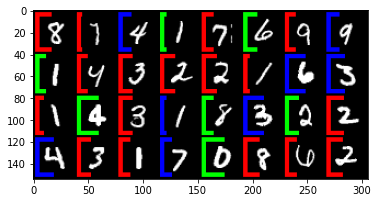

Image shape: torch.Size([3, 36, 36])


In [16]:
from plotting_utils import show_dataset_examples
show_dataset_examples(trainer)

In [17]:
from plotting_utils import get_test_sample
test_examples = get_test_sample(trainer)

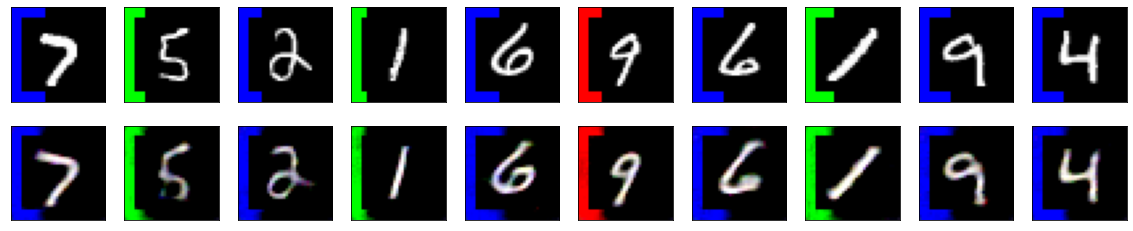

In [18]:
from plotting_utils import show_reconstruction
show_reconstruction(test_examples, trainer)

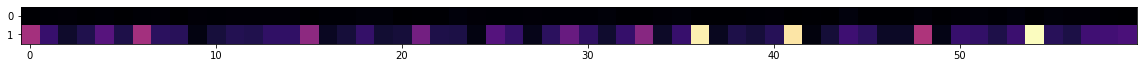

In [19]:
from models import layer_svd
import matplotlib.pyplot as plt

enc_layer = trainer.model.encoder_output_layer
u, s, v = layer_svd(enc_layer)
u = u.detach().cpu().numpy()
s = s.detach().cpu().numpy()
v = v.detach().cpu().numpy()
plt.figure(figsize=(20, 20))
plt.imshow(u[:, :ncc].transpose(1, 0), cmap="magma")

In [20]:
blocks = compute_layer_blocks_out(enc_layer, ncc)

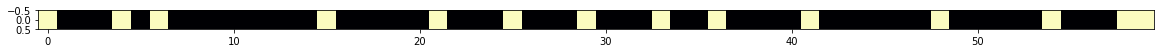

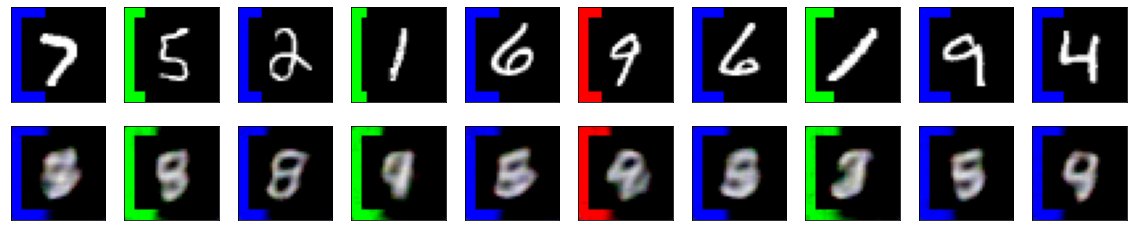

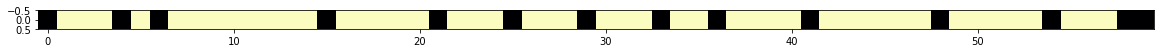

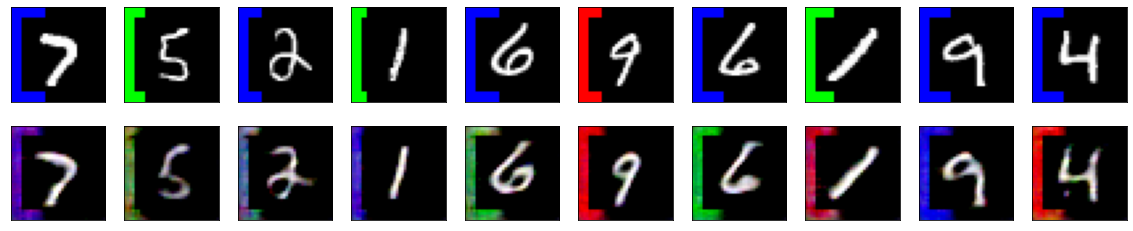

In [21]:
from plotting_utils import plot_reconstruction

for c in range(ncc):
    plt.figure(figsize=(20, 20)) 
    plt.imshow([blocks==c], cmap='magma')
    enc_layer.turn_output_neurons_off([blocks==c])
    
    show_reconstruction(test_examples, trainer)
    enc_layer.turn_all_output_neurons_on()

In [11]:
np.where(blocks==0)

(array([ 0,  2,  4,  5,  7, 10, 15, 18, 19, 20, 21, 23, 24, 27, 29, 35, 36,
        38, 42, 43, 44, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]),)

In [12]:
for c in range(ncc):
    print("block {}".format(c))
    for n in np.where(blocks==c)[0]:
        mask = torch.zeros(60, dtype=torch.float)
        mask[n] = 1
        print(n)
        enc_layer.turn_output_neurons_off(mask)

        with torch.no_grad():
            reconstruction = trainer.model(test_examples)
        plot_reconstruction(test_examples.detach(), reconstruction.detach().cpu())
        print(trainer.criterion(test_examples, reconstruction))
        enc_layer.turn_all_output_neurons_on()

block 0
0


/home/c01ekar/diseNN/models.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.out_mask = torch.tensor(mask).to(device)


RuntimeError: The size of tensor a (60) must match the size of tensor b (57) at non-singleton dimension 1

In [ ]:
relative_error = [None]*bn_size
for c in range(ncc):
    mask = torch.zeros(60, dtype=torch.float)
    mask[blocks==c] = 1
    enc_layer.turn_output_neurons_off(mask)
    with torch.no_grad():
        reconstruction = trainer.model(test_examples)
    block_error = trainer.criterion(test_examples, reconstruction).item()
    enc_layer.turn_all_output_neurons_on()
        
    #print("block {}".format(c))
    for n in np.where(blocks!=c)[0]:
        mask = torch.zeros(60, dtype=torch.float)
        mask[blocks==c] = 1
        mask[n] = 1
        #print(n)
        #plt.figure(figsize=(20, 20)) 
        #plt.imshow(mask.unsqueeze(0), cmap='magma')
        enc_layer.turn_output_neurons_off(mask)

        with torch.no_grad():
            reconstruction = trainer.model(test_examples)
        #plot_reconstruction(test_examples.detach(), reconstruction.detach().cpu())
        relative_error[n] = block_error - trainer.criterion(test_examples, reconstruction).item()
        enc_layer.turn_all_output_neurons_on()

In [ ]:
relative_error

In [ ]:

plt.figure()
plt.hist(np.array(relative_error)[blocks==0])
plt.figure()
plt.hist(np.array(relative_error)[blocks==1])
thr = np.percentile(np.array(relative_error), 20)
re_mask = np.array([e>thr for e in relative_error])
re_mask.sum()

In [ ]:
for c in range(ncc):
    mask = np.logical_and(np.array(blocks==c), re_mask)
    plt.figure(figsize=(20, 20)) 
    plt.imshow(torch.tensor(mask).unsqueeze(0), cmap='magma')
    enc_layer.turn_output_neurons_off(mask)
    
    show_reconstruction(test_examples, trainer)
    enc_layer.turn_all_output_neurons_on()

In [ ]:
srt_enc = np.argsort(v.transpose(1, 0)[:, 1]).tolist()
srt_hidden = np.argsort(u.transpose(1, 0)[:, 1]).tolist()

trainer.model.set_mask(None)

w1 = trainer.model.encoder_output_layer.weight.cpu().detach()
w1 = w1[:, srt_enc]
w1 = w1[srt_hidden, :]


In [ ]:
srt_enc

In [ ]:
plt.figure(figsize=(20, 20)) 
plt.imshow((w1).cpu().numpy(), cmap='magma')

In [ ]:
binned_examples = [[[] for _ in range(3)] for _ in range(10)]
for batch_features in trainer.test_loader:
    batch_features, (digit, _, clr) = batch_features
    for i in range(len(batch_features)):
        binned_examples[digit[i].item()][clr[i].item()].append(batch_features[i].to(device))

In [ ]:
for d in range(10):
    for clr in range(3):
        binned_examples[d][clr] = torch.stack(binned_examples[d][clr]).to(device)
        print(binned_examples[d][clr].shape)

In [ ]:
losses = []
for _ in range(ncc):
    losses.append(torch.zeros((3, 10)))
    
for c in range(ncc):
    mask = torch.zeros(w.shape)
    mask.shape
    mask[blocks==c] = 1
    plt.figure(figsize=(20, 20)) 
    plt.imshow(mask[:, :1].transpose(1, 0), cmap='magma')
    trainer.model.set_mask(mask)
    
    for clr in range(3):
        for d in range(10):
            with torch.no_grad():
                reconstruction = trainer.model(binned_examples[d][clr]).cpu()
            show_reconstruction(binned_examples[d][clr], reconstruction)
            losses[c][clr][d] = trainer.criterion(binned_examples[d][clr], reconstruction.cuda())

In [ ]:

for c in range(ncc):
    plt.grid(False)
    plt.imshow(losses[c], cmap="magma")
    plt.show()
    print(losses[c])

           

In [ ]:
print(losses[0].sum(0))
print(losses[0].sum(1))
print(losses[1].sum(0))
print(losses[1].sum(1))

In [ ]:
def block_dropout(blocks, prob):
    mask = torch.zeros(len(blocks), dtype=torch.bool)
    first_mask = torch.rand(((blocks==0).sum(), )) < prob
    mask[blocks==0] = first_mask
    p = first_mask.sum()/len(first_mask)
    for i in range(1, max(blocks)+1):
        new_mask = torch.zeros(((blocks==i).sum(), ), dtype=torch.bool)
        new_mask[:int(p*len(new_mask))] = 1
        mask[blocks==i] = new_mask[torch.randperm(len(new_mask))]

    return mask.float()

block_dropout(blocks, 0.2)

In [ ]:
b_test = np.array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0])
for i in range(20):
    d = block_dropout(b_test, 0.3)
    print(d[:8].sum().item(), d[8:].sum().item())
    print(d)

# T-SNE

In [ ]:
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [ ]:
# Utility function to visualize the outputs of PCA and t-SNE
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123

def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [ ]:
embeddings = []
targets = []
d_targets = []
c_targets = []
for batch_features, (digit, _, clr) in trainer.test_loader:
    with torch.no_grad():
        reconstruction = trainer.model(batch_features).cpu()
        embeddings.append(trainer.model.embedding)
        d_targets.extend(digit.tolist())
        c_targets.extend(clr.tolist())
        #targets.extend([str(d)+"_"+str(c) for d, c in zip(digit.tolist(), clr.tolist())])

In [ ]:
df_emb = torch.vstack(embeddings).detach().cpu().numpy()
targets = [c*10+d for d, c in zip(d_targets, c_targets)]

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_emb)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
fashion_scatter(tsne_results, np.array(targets))


In [ ]:
fashion_scatter(tsne_results, np.array(c_targets))

In [ ]:
fashion_scatter(tsne_results, np.array(d_targets))

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_block0 = tsne.fit_transform(df_emb[:, blocks==0])
tsne_results_block1 = tsne.fit_transform(df_emb[:, blocks==1])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
fashion_scatter(tsne_results_block0, np.array(c_targets))

In [ ]:
fashion_scatter(tsne_results_block0, np.array(d_targets))

In [ ]:
fashion_scatter(tsne_results_block1, np.array(c_targets))

In [ ]:
fashion_scatter(tsne_results_block1, np.array(d_targets))

# Dependencies between blocks

In [ ]:
plt.rcParams["axes.grid"] = False
plt.figure(figsize=(20, 20)) 
plt.imshow(np.cov(df_emb[:, blocks==0].transpose(1, 0)))
plt.colorbar()

In [ ]:
plt.figure(figsize=(20, 20)) 
plt.imshow(np.cov(df_emb[:, blocks==1].transpose(1, 0)))
plt.colorbar()

In [ ]:
full_corr = np.corrcoef(df_emb[:, blocks==0].transpose(1, 0), df_emb[:, blocks==1].transpose(1, 0))
plt.figure(figsize=(20, 20)) 
plt.imshow(full_corr)
plt.colorbar()

In [ ]:
full_corr = np.corrcoef(df_emb[:, blocks==0].transpose(1, 0), df_emb[:, blocks==1].transpose(1, 0))
plt.figure(figsize=(20, 20)) 
plt.imshow(full_corr)
plt.colorbar()

In [ ]:
dist = np.zeros((bn_size, bn_size))
for i in range(bn_size):
    for j in range(i, bn_size):
        dist[i, j] = np.abs(full_corr[i]-full_corr[j]).sum()
        dist[j, i] = np.abs(full_corr[i]-full_corr[j]).sum()
        
plt.figure(figsize=(20, 20)) 
plt.imshow(dist<5)
plt.colorbar()

plt.figure(figsize=(20, 20)) 
plt.hist(dist.flatten())

# Collect activations

In [ ]:
from explainn_code.grab_functions import db_from_dat_with_labels, write_pic_as_sets

activations = []
test_data = []
for batch_features, (digit, _, clr) in trainer.test_loader:
    with torch.no_grad():
        reconstruction = trainer.model(batch_features).cpu()
        activations.append(trainer.model.layer_0_out.detach().cpu().numpy())
        test_data.append(batch_features.detach().cpu().numpy())
activations = np.concatenate(activations)


In [ ]:
for i in range(6):
    write_pic_as_sets(activations[:, i, :].reshape(activations.shape[0], -1), "filters_{}.dat".format(i))

In [ ]:
test_data = np.concatenate(test_data)
write_pic_as_sets(test_data.reshape(test_data.shape[0], -1), "test_data.dat")

In [ ]:
for i in range(6):
    db_from_dat_with_labels("filters_{}.dat".format(i), "test_data.dat", "data{}.db".format(i))